<a href="https://colab.research.google.com/github/reddragon/book/blob/main/codelabs/MNIST_Quantization_Including_QAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quantizing a Deep Learning Model

## Collecting the Dataset

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from keras.utils import np_utils

import tensorflow_datasets as tfds

def process_x(x):
  """Process the given tensors of images."""
  x = x.astype(np.float32)

  # The original data is in [0.0, 255.0].
  # This normalization helps in making them lie between [-1.0, 1.0].
  x /= 127.5
  x -= 1.0

  # Add one dimension for the channels.
  x = np.expand_dims(x, 3)
  return x

def load_data(ds=tf.keras.datasets.mnist):
  """Returns the processed dataset."""
  (train_images, train_labels), (test_images, test_labels) = ds.load_data()

  # Process the images for use.
  train_images = process_x(train_images)
  test_images = process_x(test_images)

  return (train_images, train_labels), (test_images, test_labels)

(train_x, train_y), (test_x, test_y) = load_data()

# You can train on the Fashion MNIST dataset, which has the exact same format
# as MNIST, and is slightly harder.
# (train_x, train_y), (test_x, test_y) = load_data(ds=tf.keras.datasets.fashion_mnist)

## Visualize the dataset

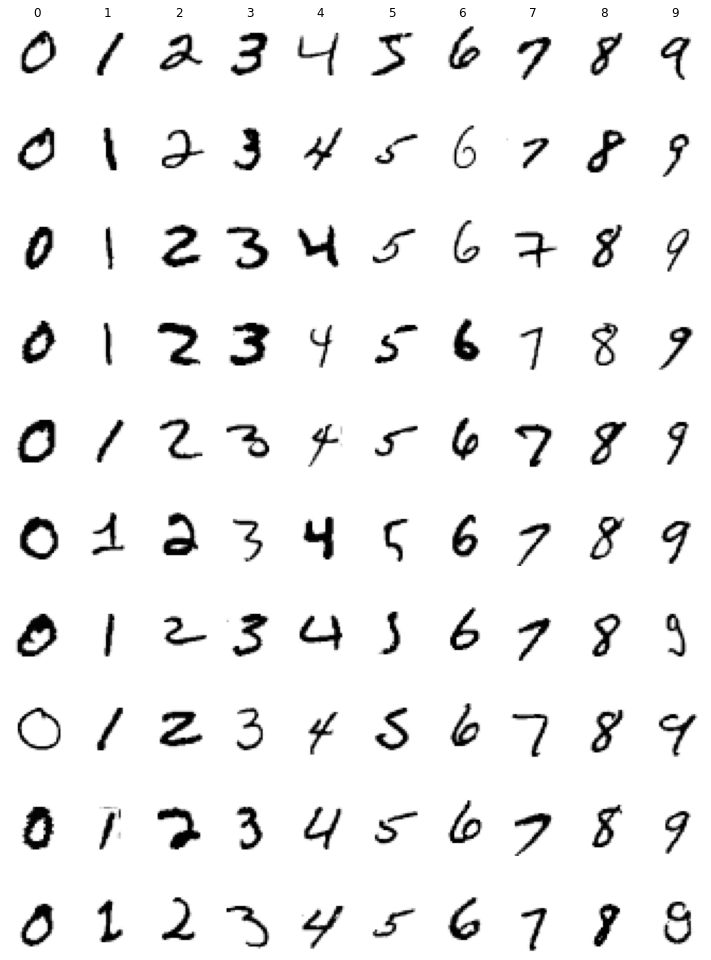

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

def collect_samples(x, y, num_classes=10, num_per_class=5):
  sampled_x = None
  sampled_x_idx = 0
  for class_idx in range(num_classes):
    num_collected = 0
    for idx in range(len(x)):
      if num_collected == num_per_class:
        break

      if y[idx] != class_idx:
        continue

      if sampled_x is not None:
        sampled_x = np.concatenate((sampled_x, np.expand_dims(x[idx], 0)))
      else:
        sampled_x = np.expand_dims(x[idx], 0)
      sampled_x_idx = sampled_x_idx + 1
      num_collected = num_collected + 1

  return sampled_x

def show_images(images, num_rows = 1, titles = None):
    """Display a list of images in a single figure with matplotlib. """
    # assert((titles is None)or (len(images) == len(titles)))
    num_images = len(images)
    num_cols = num_images // num_rows

    # plot images
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(1.25 * num_rows, 1.75 * num_cols))
    
    for i in range(num_images):
      ax = axes[i%num_cols, i//num_cols]
      ax.axis('off')
      ax.imshow(np.squeeze(images[i]), cmap='Greys')
      # ax.add_axes((0, 0, 1, 1))
      if i % num_cols == 0:
        ax.set_title('{}'.format(int(i / num_rows)))
    # plt.tight_layout()
    plt.show()
  
show_images(collect_samples(train_x, train_y, num_per_class=10), num_rows=10)

In [3]:
## Create and compile the model

In [4]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

def create_model(dropout_rate=0.0):
  """Create a simple convolutional network."""
  inputs = keras.Input(shape=(28, 28, 1))
  x = inputs
  x = layers.Conv2D(32, (3, 3))(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)
  x = layers.MaxPooling2D(pool_size=(2, 2))(x)

  x = layers.Conv2D(64, (3, 3))(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)
  x = layers.MaxPooling2D(pool_size=(2, 2))(x)

  x = layers.Flatten()(x)
  x = layers.Dropout(dropout_rate)(x)
  x = layers.Dense(10)(x)
  return keras.Model(inputs=inputs, outputs=x)

def get_compiled_model():
  """Create a compiled model (with loss fn, optimizer, metrics, etc.)"""
  model = create_model()
  opt = keras.optimizers.Adam()
  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                optimizer=opt, 
                metrics=tf.keras.metrics.SparseCategoricalAccuracy())
  return model

get_compiled_model()

## Training without TFLite Model Generation

In [5]:
def train_basic_model():
  model = get_compiled_model()
  model.summary()

  model_history = model.fit(
      train_x, 
      train_y, 
      batch_size=128, 
      epochs=15, 
      validation_data=(test_x, test_y),
      shuffle=True)

  return model, model_history.history

In [6]:
basic_mnist_model, basic_mnist_model_history = train_basic_model()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_2 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
batch_normalization_3 (Batch (None, 11, 11, 64)        256 

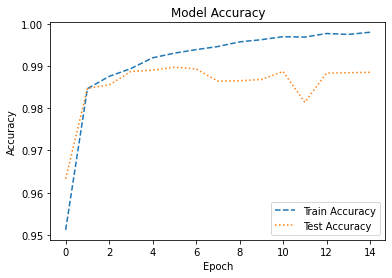

In [7]:
plt.plot(
    basic_mnist_model_history['sparse_categorical_accuracy'], 
    linestyle='dashed')
plt.plot(
    basic_mnist_model_history['val_sparse_categorical_accuracy'], 
    linestyle='dotted')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train Accuracy', 'Test Accuracy'], loc='lower right')
plt.show()

## Helper functions for TFLite conversion and evaluation

In [8]:
def tflite_model_eval(model_content, test_images, test_labels, quantized):
  """Evaluate the generated TFLite model."""
  # Load the TFLite model and allocate tensors.
  interpreter = tf.lite.Interpreter(model_content=model_content)
  interpreter.allocate_tensors()

  # Get input and output tensors.
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()

  num_correct = 0
  num_total = 0

  for idx in range(len(test_images)):
    num_total = num_total + 1

    input_data = test_images[idx:idx+1]
    if quantized:
      # If the model is quantized, then we would have to provide the input 
      # in [-127,127].
      # Rescale that data to be in [-127, 127] and then convert to int8.
      input_data = (input_data * 127).astype(np.int8)

    # Set the input tensor and invoke the interpreter.
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()

    output_data = interpreter.get_tensor(output_details[0]['index'])

    # The returned output is a tensor of logits, so we find the maximum in that 
    # tensor, and see if it matches the label.
    if np.argmax(output_data[0]) == test_labels[idx]:
      num_correct = num_correct + 1
  
  print('Accuracy:', num_correct * 1.0 / num_total)

In [9]:
# Create the directory for storing TFLite models.
!mkdir -p 'tflite_models'

def convert_and_eval(model, model_name, quantized_export, test_dataset_x, 
                     test_dataset_y):
  """Helper method to convert the given model to TFLite and eval it."""
  # Set up the converter.
  converter = tf.lite.TFLiteConverter.from_keras_model(model)

  if quantized_export:
    converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE, 
                               tf.lite.Optimize.OPTIMIZE_FOR_LATENCY]

    # Set up the representative dataset that helps improve the quality
    # of the quantized model. 
    def representative_dataset():
      for idx in range(min(len(test_dataset_x), 1000)):
        yield [test_dataset_x[idx:idx+1]]

    converter.representative_dataset = representative_dataset
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.int8  # or tf.uint8
    converter.inference_output_type = tf.int8  # or tf.uint8

  tflite_model_str = converter.convert()

  model_name = '{}_{}.tflite'.format(
      model_name, ('quantized' if quantized_export else 'float'))
  print('Model Name: {}, Quantized: {}'.format(model_name, quantized_export))
  print('Model Size: {:.2f} KB'.format(len(tflite_model_str) / 1024.))
  with open(os.path.join('tflite_models', model_name), 'wb') as f:
    f.write(tflite_model_str)
  
  # Evaluate the model.
  tflite_model_eval(tflite_model_str, test_dataset_x, test_dataset_y, 
                    quantized_export)

## Chain everything together in a single train function

In [10]:
import os
import numpy as np

def train_model(batch_size=128, epochs=100, model_name='mnist_model'):
  model = get_compiled_model()
  model.summary()

  model_history = model.fit(
      train_x, 
      train_y, 
      batch_size=batch_size, 
      epochs=epochs, 
      validation_data=(test_x, test_y),
      shuffle=True)

  print("Running Final Evaluation")
  model.evaluate(test_x, test_y)

  # Convert and evaluate both (floating point and quantized models).
  convert_and_eval(model, model_name, False, test_x, test_y)
  convert_and_eval(model, model_name, True, test_x, test_y)

  return model, model_history.history

In [11]:
mnist_model, mnist_model_history = train_model(epochs=15)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_4 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
activation_4 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
batch_normalization_5 (Batch (None, 11, 11, 64)        256 

INFO:tensorflow:Assets written to: /tmp/tmpljlefd2f/assets


Model Name: mnist_model_quantized.tflite, Quantized: True
Model Size: 39.65 KB
Accuracy: 0.9861


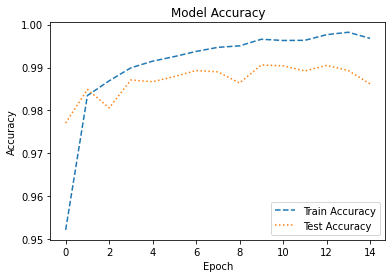

In [12]:
plt.plot(
    mnist_model_history['sparse_categorical_accuracy'], 
    linestyle='dashed')
plt.plot(
    mnist_model_history['val_sparse_categorical_accuracy'], 
    linestyle='dotted')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train Accuracy', 'Test Accuracy'], loc='lower right')
plt.show()

## Plot the model

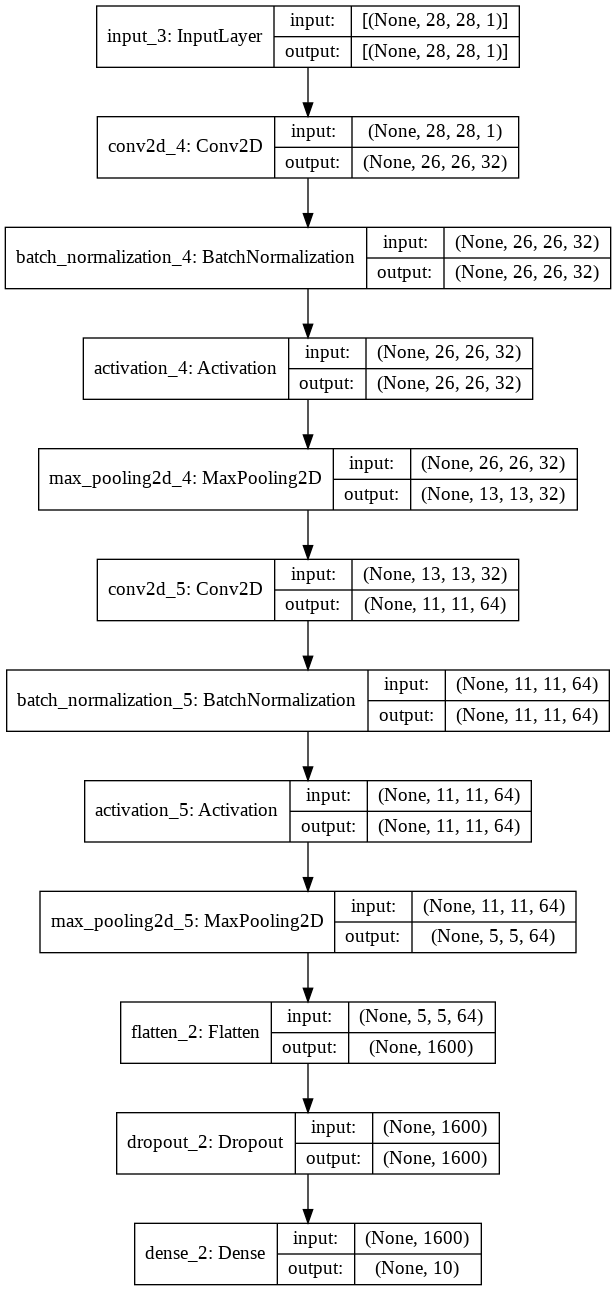

In [13]:
tf.keras.utils.plot_model(
    mnist_model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

## Quantization-Aware Training (QAT) with TFMOT

In [14]:
pip install tensorflow_model_optimization

In [15]:
import tensorflow_model_optimization as tfmot

In [16]:
quantize_model = tfmot.quantization.keras.quantize_model

In [17]:
q_aware_model = quantize_model(mnist_model)

# `quantize_model` requires a recompile.
q_aware_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=tf.keras.metrics.SparseCategoricalAccuracy())

q_aware_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
quantize_layer (QuantizeLaye (None, 28, 28, 1)         3         
_________________________________________________________________
quant_conv2d_4 (QuantizeWrap (None, 26, 26, 32)        385       
_________________________________________________________________
quant_batch_normalization_4  (None, 26, 26, 32)        129       
_________________________________________________________________
quant_activation_4 (Quantize (None, 26, 26, 32)        3         
_________________________________________________________________
quant_max_pooling2d_4 (Quant (None, 13, 13, 32)        1         
_________________________________________________________________
quant_conv2d_5 (QuantizeWrap (None, 11, 11, 64)        1862

In [18]:
q_aware_model.fit(
  train_x, 
  train_y, 
  batch_size=128, 
  epochs=15, 
  validation_data=(test_x, test_y),
  shuffle=True)

q_aware_model.evaluate(test_x, test_y)

convert_and_eval(q_aware_model, 'test', True, test_x, test_y)

Epoch 1/15
469/469 [==============================] - 9s 17ms/step - loss: 0.0091 - sparse_categorical_accuracy: 0.9970 - val_loss: 0.0381 - val_sparse_categorical_accuracy: 0.9902
Epoch 2/15
469/469 [==============================] - 8s 17ms/step - loss: 0.0069 - sparse_categorical_accuracy: 0.9977 - val_loss: 0.0467 - val_sparse_categorical_accuracy: 0.9879
Epoch 3/15
469/469 [==============================] - 8s 17ms/step - loss: 0.0055 - sparse_categorical_accuracy: 0.9981 - val_loss: 0.0492 - val_sparse_categorical_accuracy: 0.9885
Epoch 4/15
469/469 [==============================] - 8s 16ms/step - loss: 0.0046 - sparse_categorical_accuracy: 0.9985 - val_loss: 0.0402 - val_sparse_categorical_accuracy: 0.9893
Epoch 5/15
469/469 [==============================] - 8s 17ms/step - loss: 0.0049 - sparse_categorical_accuracy: 0.9984 - val_loss: 0.0491 - val_sparse_categorical_accuracy: 0.9896
Epoch 6/15
469/469 [==============================] - 8s 16ms/step - loss: 0.0034 - sparse_cate

INFO:tensorflow:Assets written to: /tmp/tmpyoiw1x_d/assets


INFO:tensorflow:Assets written to: /tmp/tmpyoiw1x_d/assets


Model Name: test_quantized.tflite, Quantized: True
Model Size: 40.08 KB
Accuracy: 0.9911
